In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("./input"))


['input']


In [2]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

# Have you installed your own package in Kernels yet? 
# If you need to, you can use the "Settings" bar on the right to install `simplification`
# from simplification.cutil import simplify_coords

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
BATCH_SIZE=4096
MAX_STROKE_LENGTH=130
EPOCHS=10
TRAIN_SAMPLES=750
VALID_SAMPLES=75
TEST_SAMPLES=50
TRAIN_PATH='./input/input/train_simplified'
TEST_PATH='./input/input/test_simplified.csv'
INIT_LR=1e-2
MODEL_NAME='lstm_deep1.hdf5'

## Data extraction

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(string_data):
    simplified_images = [ast.literal_eval(lst) for lst in string_data]
    
    del string_data
    
    strokes = []
    for image in simplified_images:
        stroke = [(xi, yi, i) for (i, (x, y)) in enumerate(image)
                             for xi, yi in zip(x, y)]
        stroke = np.asarray(stroke)
        
        stroke[:,2] = [1] + np.diff(stroke[:,2]).tolist()
        stroke[:,2] += 1
        
        stroke = pad_sequences([stroke], maxlen=MAX_STROKE_LENGTH, padding='post')
        
        stroke = np.squeeze(stroke)
        strokes.append(stroke)
        del stroke
    
    del simplified_images
    
    return np.asarray(strokes)
    
        
 

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

def read_batch(start=0, end=TRAIN_SAMPLES):
    sample_list = os.listdir(TRAIN_PATH)
    labels = []
    data = []
    for sample in sample_list:
        sample_data = pd.read_csv(os.path.join(TRAIN_PATH, sample), nrows=end, skiprows=range(1, start))
        sequences = get_sequences(sample_data['drawing'].values)
        sample_labels = sample_data['word'].replace(' ', '_', regex=True)
        data.append(sequences)
        labels.extend(sample_labels)
        del sample_data
        del sequences
        del sample_labels
        gc.collect()
        
    encodings = label_encoder.fit_transform(labels)
    
    data = np.concatenate(data, axis=0)
    one_hot = to_categorical(encodings)
    
    del encodings
    del labels
    del sample_list
    
    return data, one_hot

In [6]:
from sklearn.model_selection import train_test_split
test_x, test_y = read_batch(start=0, end=TEST_SAMPLES)

In [13]:
sub_df = pd.read_csv(TEST_PATH)
sequences = get_sequences(sub_df['drawing'].values)

In [7]:
#train_x, train_y = read_batch(start=TEST_SAMPLES + TRAIN_SAMPLES, end=TRAIN_SAMPLES)

In [8]:
# print("train x: ", train_x.shape)
# print("test x: ", test_x.shape)

In [7]:
def draw_images(images):
    for index, drawing in enumerate(images[0:20], 0):
        tmp = np.array(drawing)
        plt.figure(figsize=(6,3))

        plt.gca().invert_yaxis()
        plt.axis('equal')

        for x, y in drawing:
            plt.subplot(1,2,2)
            plt.plot(x, y, marker='.')
            plt.axis('off')

        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.show()  

In [8]:
def draw_train_data():
    plt.figure(figsize=(6,3))

    plt.gca().invert_yaxis()
    plt.axis('equal')

    for i in range(5,6):
        stroke = strokes[i]
        mask = stroke[:,2] != 0
        stroke = stroke[mask,:]
        print(stroke.shape)
        x, y = stroke[:,0:2].T

        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()  

## Training

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [5]:
from tensorflow.keras.layers import LSTM, Dense, Conv1D, LeakyReLU, BatchNormalization, MaxPool1D, Dropout
from tensorflow.keras.models import Model
GPUs = get_available_gpus()
if len(GPUs) > 0:
    print('GPUs: ', GPUs)
    from tensorflow.keras.layers import CuDNNLSTM as LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

GPUs:  ['/device:GPU:0']


In [13]:
# model = Sequential()
# model.add(BatchNormalization(input_shape=(None, 3)))
# model.add(Conv1D(64, (5), padding='same', activation=None))
# model.add(LeakyReLU())
# model.add(MaxPool1D())
# model.add(BatchNormalization())

# model.add(Conv1D(128, (5), padding='same', activation=None))
# model.add(LeakyReLU())
# model.add(MaxPool1D())
# model.add(BatchNormalization())

# model.add(Conv1D(256, (5), padding='same', activation=None))
# model.add(LeakyReLU())
# model.add(MaxPool1D())
# model.add(BatchNormalization())

# model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(256, return_sequences=False))

# model.add(Dense(512, activation=None))
# model.add(LeakyReLU())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Dense(test_y.shape[1], activation='softmax'))

In [14]:
# model.summary()

In [15]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS), 
#               metrics=['accuracy'])

In [11]:
def default_callbacks(model_name=MODEL_NAME):
    checkpoint = ModelCheckpoint(filepath=model_name, save_best_only=True, verbose=1)
    plateo = ReduceLROnPlateau(factor=0.5, verbose=1, patience=4)
    early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=6, verbose=1)
    return [checkpoint, plateo, early]

In [17]:
# loss_history = model.fit(train_x, train_y, batch_size=BATCH_SIZE,
#                   validation_data=(test_x, test_y),
#                   epochs=EPOCHS,
#                   callbacks=[checkpoint, plateo, early])

In [7]:
from tensorflow.keras.models import load_model
model = load_model('final1.hdf5')

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [9]:
pydot

<module 'pydot' from '/home/ivanhahanov/DoodleRecognition/venv/lib/python3.5/site-packages/pydot.py'>

In [11]:
import tensorflow
tensorflow

<module 'tensorflow' from '/home/ivanhahanov/DoodleRecognition/venv/lib/python3.5/site-packages/tensorflow/__init__.py'>

In [ ]:
from tensorflow.keras.models import load_model
import sys
from numba import cuda

# model = load_model('final1.hdf5')
histories = []
# for epoch in range(2):
callbacks = default_callbacks(model_name='best1.hdf5')
for i in range(30,152):
#     print('EPOCH: ', epoch)
    print('\n\nBATCH: ', i)
    model = load_model('final1.hdf5')
    lr = 0.001#(INIT_LR / ((epoch + 1)*2 + i/9))
    print('lr: ', lr)
    adam = Adam(lr=lr, decay=lr / 5)
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']
    train_x, train_y = read_batch(start=TEST_SAMPLES + TRAIN_SAMPLES*i, end=TRAIN_SAMPLES)
    model.compile(optimizer=adam, metrics=metrics, loss=loss)
    loss_history = model.fit(train_x, train_y, batch_size=BATCH_SIZE,
              validation_data=(test_x, test_y),
              epochs=1,
              callbacks=callbacks)
    histories.append(loss_history) 
    model.save('final1.hdf5')
    tf.keras.backend.clear_session()
    del train_x
    del train_y
    del loss_history
    del model
    del adam
    del loss
    del metrics
    del lr
    model = None
    gc.collect()
    sys.stdout.flush()
#         cuda.close()
#         cuda.select_device(0)

    for i in range(0, 2):
        tf.keras.backend.clear_session()
        gc.collect()
        sys.stdout.flush()

        
for epoch in range(0, 2):
    for i in range(0,152):
    #     print('EPOCH: ', epoch)
        print('\n\nBATCH: ', i)
        model = load_model('final1.hdf5')
        lr = 0.0007 / (epoch + 1)#(INIT_LR / ((epoch + 1)*2 + i/9))
        print('lr: ', lr)
        adam = Adam(lr=lr, decay=lr / 5)
        loss = 'categorical_crossentropy'
        metrics = ['accuracy']
        train_x, train_y = read_batch(start=TEST_SAMPLES + TRAIN_SAMPLES*i, end=TRAIN_SAMPLES)
        model.compile(optimizer=adam, metrics=metrics, loss=loss)
        loss_history = model.fit(train_x, train_y, batch_size=BATCH_SIZE,
                  validation_data=(test_x, test_y),
                  epochs=1,
                  callbacks=callbacks)
        histories.append(loss_history) 
        model.save('final1.hdf5')
        tf.keras.backend.clear_session()
        del train_x
        del train_y
        del loss_history
        del model
        del adam
        del loss
        del metrics
        del lr
        model = None
        gc.collect()
        sys.stdout.flush()
#         cuda.close()
#         cuda.select_device(0)

        for i in range(0, 2):
            tf.keras.backend.clear_session()
            gc.collect()
            sys.stdout.flush()
        




BATCH:  30
lr:  0.001
Train on 255000 samples, validate on 17000 samples
Epoch 1/1
253952/255000 [============================>.] - ETA: 0s - loss: 0.9091 - acc: 0.7663
Epoch 00001: val_loss improved from inf to 0.86999, saving model to best1.hdf5
255000/255000 [==============================] - 54s 213us/step - loss: 0.9092 - acc: 0.7663 - val_loss: 0.8700 - val_acc: 0.7709


BATCH:  31
lr:  0.001
Train on 255000 samples, validate on 17000 samples
Epoch 1/1
253952/255000 [============================>.] - ETA: 0s - loss: 0.9083 - acc: 0.7663
Epoch 00001: val_loss did not improve from 0.86999
255000/255000 [==============================] - 42s 165us/step - loss: 0.9084 - acc: 0.7663 - val_loss: 0.8725 - val_acc: 0.7701


BATCH:  32
lr:  0.001
Train on 255000 samples, validate on 17000 samples
Epoch 1/1
253952/255000 [============================>.] - ETA: 0s - loss: 0.9068 - acc: 0.7664
Epoch 00001: val_loss did not improve from 0.86999
255000/255000 [==============================]

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
sys.stdout.flush()

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(MODEL_NAME)

In [ ]:
loaded_model.summary()

In [ ]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=INIT_LR / 2, decay=INIT_LR / EPOCHS), 
              metrics=['accuracy'])

In [ ]:
loss_history = loaded_model.fit(train_x, train_y, batch_size=BATCH_SIZE,
                  validation_data=(test_x, test_y),
                  epochs=EPOCHS,
                  callbacks=[checkpoint, plateo, early])

In [ ]:
loaded_model.save('lstm4.hdf5')

### Plot Data

In [ ]:
plt.plot(loss_history.history['acc'])
plt.plot(loss_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss_history.history['loss'])
plt.plot(loss_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
predictions = model.predict(test_x, batch_size=BATCH_SIZE)

In [9]:
predictions = np.argmax(predictions, -1)
predictions = label_encoder.inverse_transform(np.squeeze(predictions))

In [10]:
predictions[:3]

array(['ambulance', 'ambulance', 'ambulance'], dtype='<U23')

In [75]:
indices = np.random.choice(len(predictions), size=20)

predictions = predictions[indices]
samples = test_x[indices]

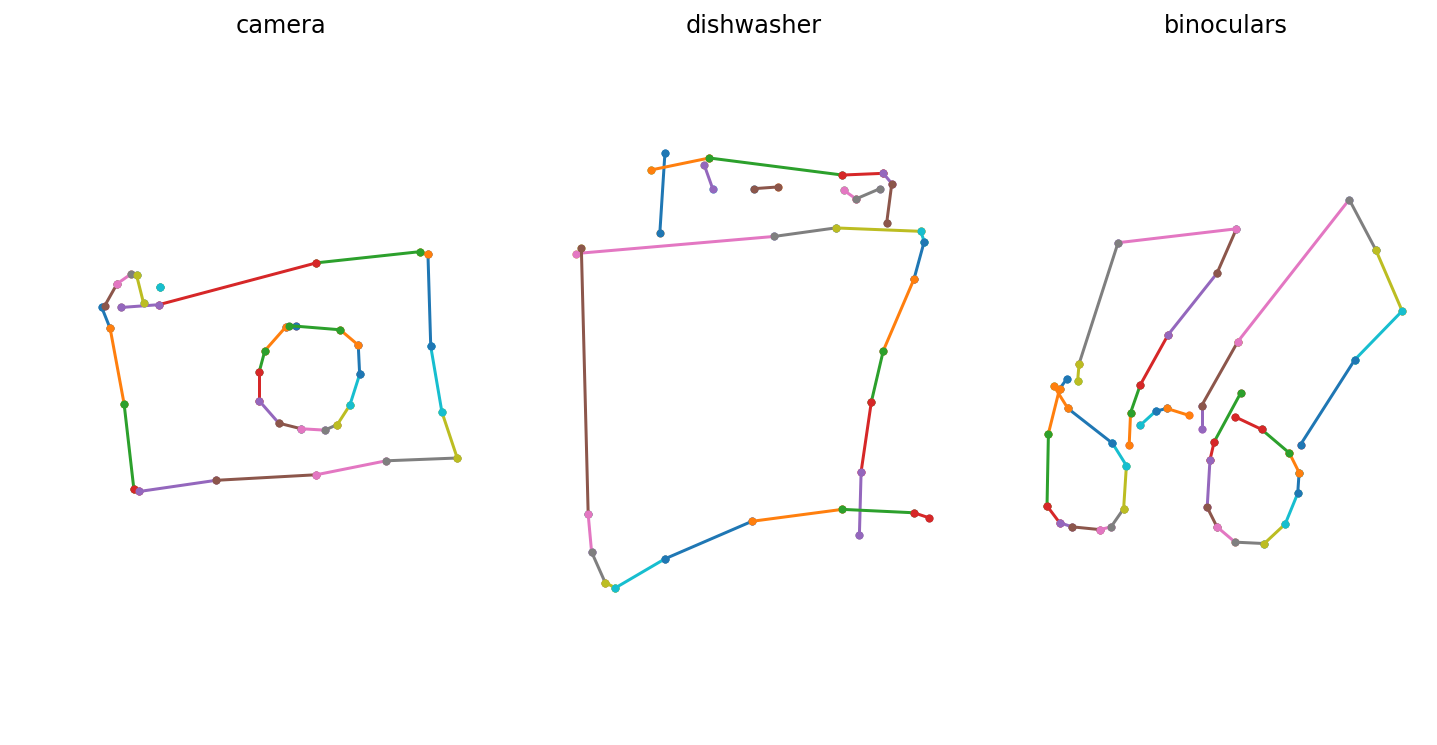

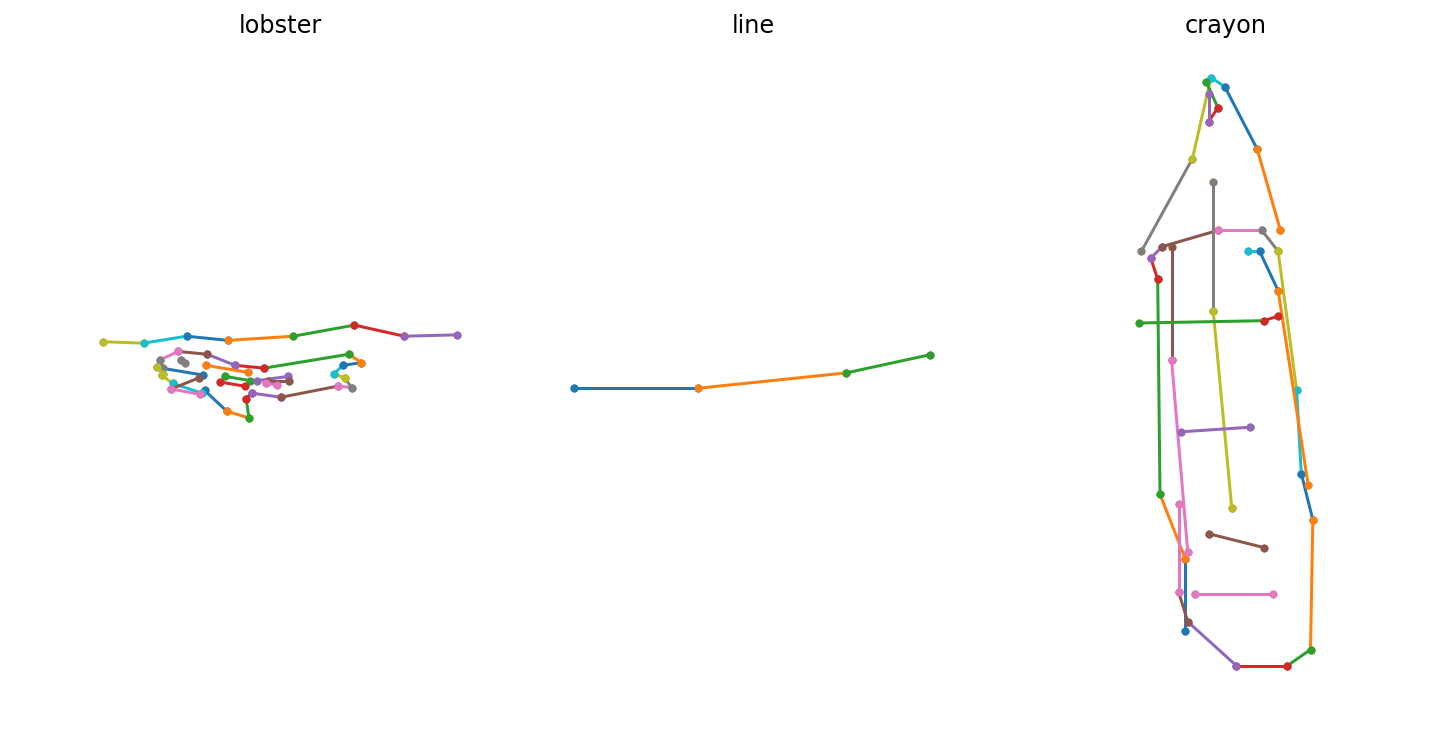

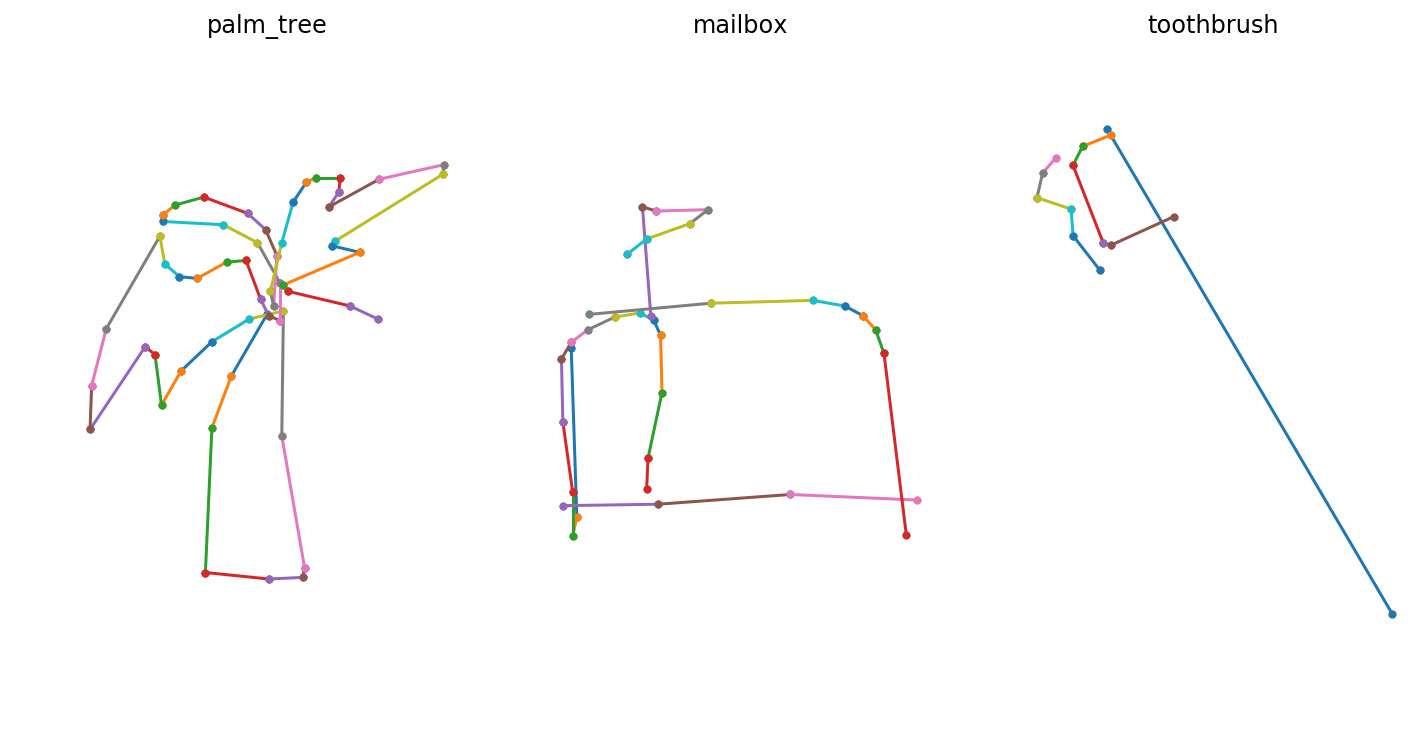

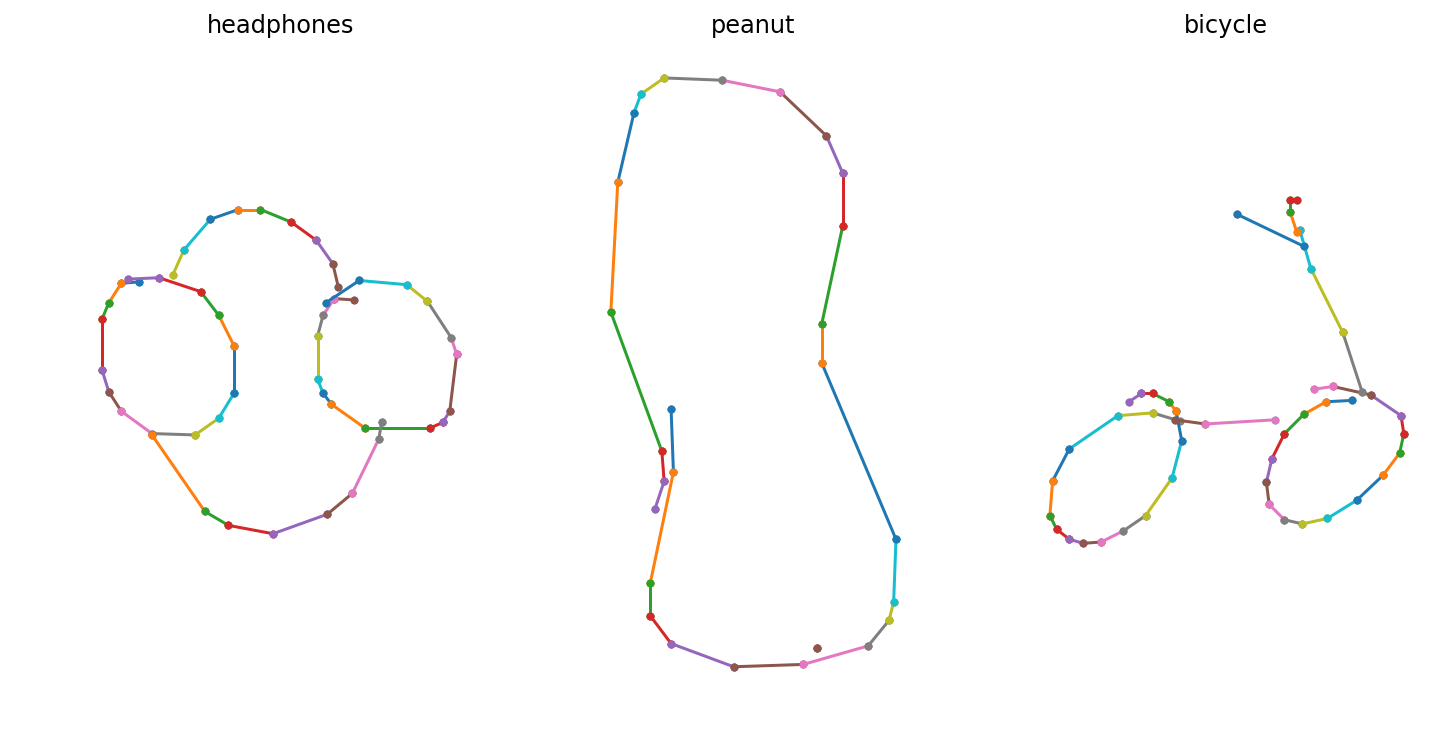

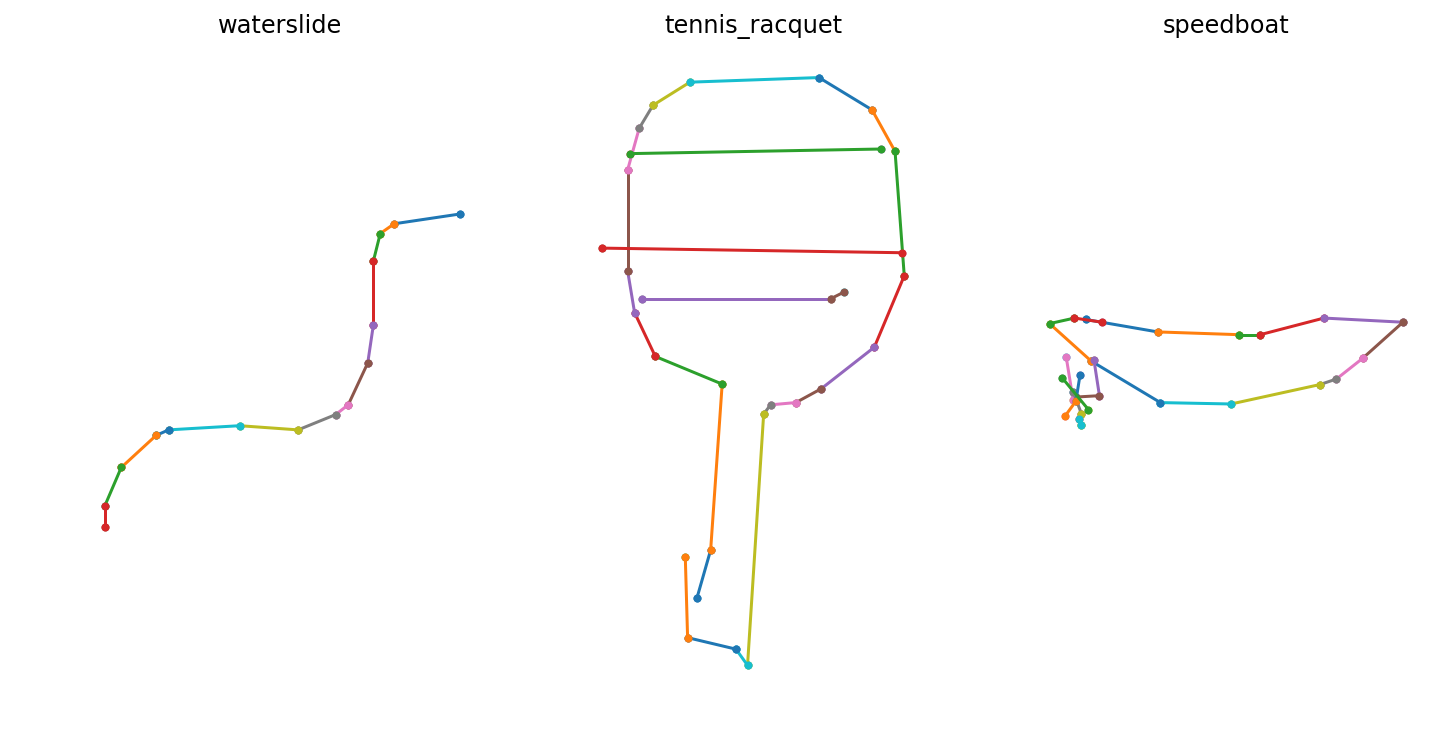

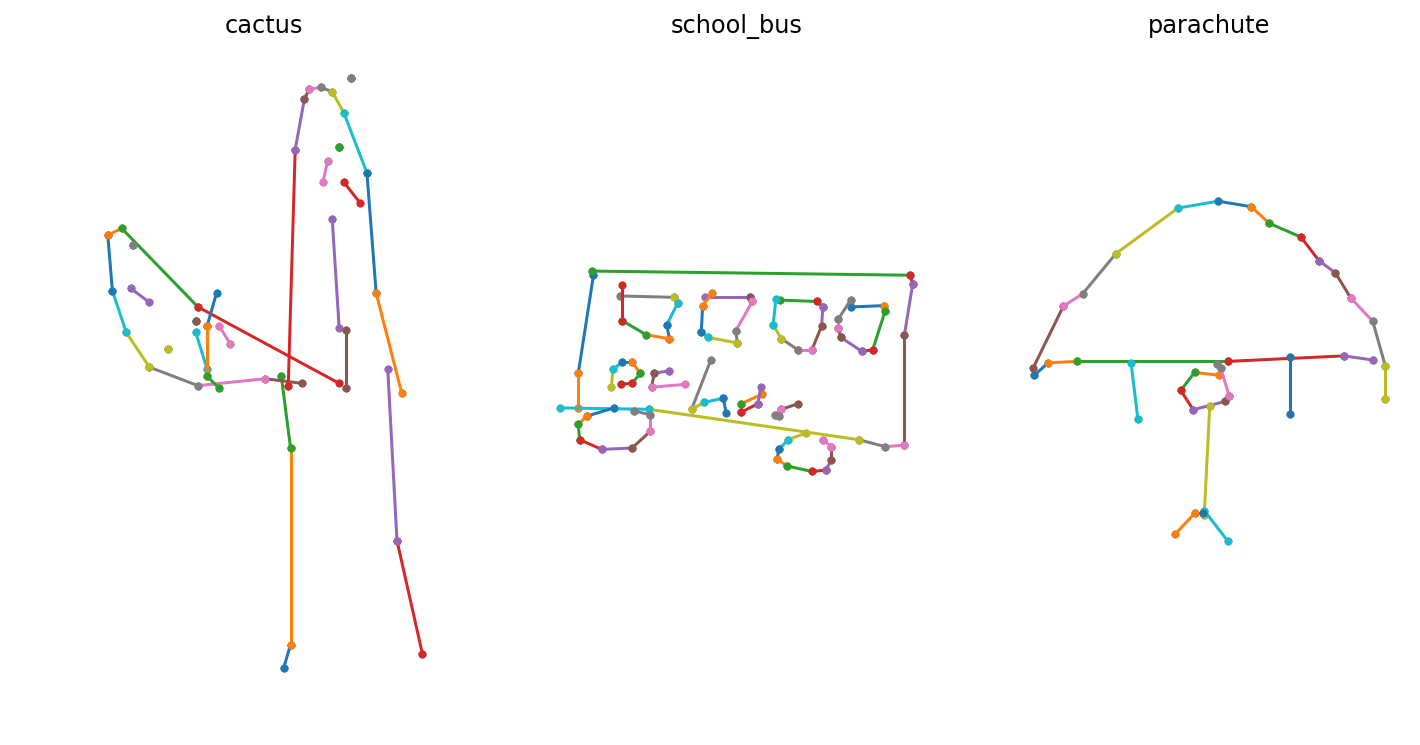

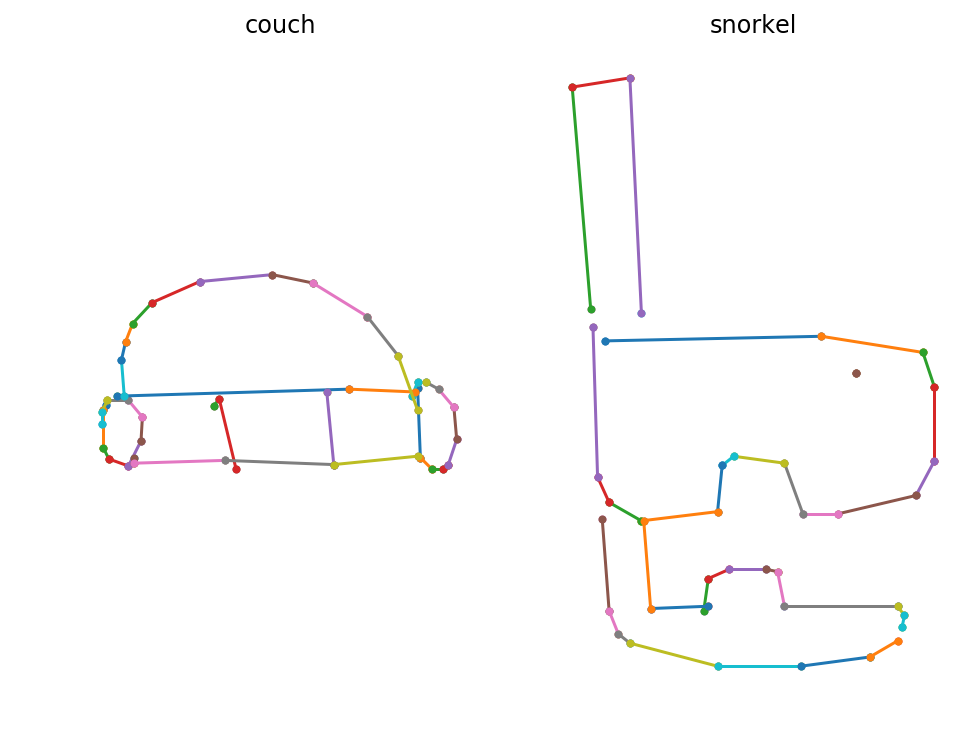

In [77]:
i=0

for drawing, prediction in zip(samples, predictions):
    tmp = np.array(drawing)
    if i % 3 == 0:
        plt.figure(figsize=(12, 6))
    plot = plt.subplot(1, 3, i % 3 + 1)
    plot.set_title(prediction)
    
    plt.axis('equal')

    plot.axis('off')
    
    for x, y, stroke in drawing:
        if stroke == 0:
            continue
        plot.scatter(x, y, marker='.')
        if stroke == 1:
            plot.plot([prev_x, x], [prev_y, y], '.-')
        prev_x, prev_y = x, y

    plt.gca().invert_yaxis()
    i += 1
    if i % 3 == 0:
        plt.show()  

## Submission

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='key_id')
# Don't forget, your multi-word labels need underscores instead of spaces!
my_favorite_words = ['donut', 'roller_coaster', 'smiley_face']  
submission['word'] = " ".join(my_favorite_words)
submission.to_csv('my_favorite_words.csv')